# Computing features to train a MLP
This notebook will guide you through the use of the `keras` package to train a multilayer perceptron for handwritten digits classification. You are going to computing the histogram of gradients from the images in the `mnist` dataset (LeCun et al. 1998)

## Loading the packages

In [1]:
%pip install tensorflow --upgrade
%pip install keras --upgrade

import numpy as np
from matplotlib import pyplot as pl

from skimage.feature import hog
from skimage import data, color, exposure

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import to_categorical

%matplotlib inline

Note: you may need to restart the kernel to use updated packages.



c:\Users\emily\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Load the `mnist` dataset and normalize in the range [0, 1]

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

n_train, height, width = X_train.shape
n_test, _, _ = X_test.shape

X_train = X_train.reshape(n_train, height, width, 1).astype('float32')
X_test = X_test.reshape(n_test, height, width, 1).astype('float32')

X_train /= 255.0
X_test /= 255.0

n_classes = 10

print(n_train, 'train samples')
print(n_test, 'test samples')

# convert class vectors to binary class matrices
Y_train = to_categorical(y_train, n_classes)
Y_test = to_categorical(y_test, n_classes)

60000 train samples
10000 test samples


### An example of how to compute the histogram of gradients
Let's compute the HOG for one image in the test dataset

In [3]:
n_orientations = 8
pix_p_cell = 4
hog_size = int(height * width * n_orientations / (pix_p_cell * pix_p_cell))

In [4]:
fd, hog_image = hog(X_test[0,:,:,0], orientations=n_orientations, pixels_per_cell=(pix_p_cell, pix_p_cell), cells_per_block=(1, 1), visualize=True)
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 0.02))

Show the image and the corresponding gradients

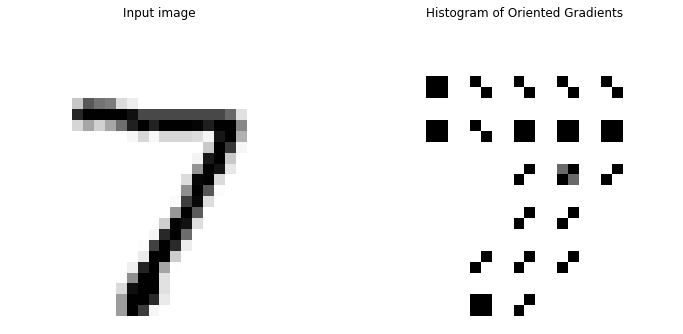

In [5]:
fig, (ax1, ax2) = pl.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
ax1.axis('off')
ax1.imshow(X_test[0,:,:,0], cmap=pl.get_cmap('Greys'), interpolation='nearest')
ax1.set_title('Input image')
ax1.set_adjustable('box')

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=pl.get_cmap('Greys'), interpolation='nearest')
ax2.set_title('Histogram of Oriented Gradients')
ax1.set_adjustable('box')

Compute the HOGs for the train and test datasets


In [6]:
X_train_hog = np.zeros((X_train.shape[0], hog_size))
X_test_hog = np.zeros((X_test.shape[0], hog_size))

for i in np.arange(X_train_hog.shape[0]):
    X_train_hog[i,:] = hog(X_train[i,:,:,0], orientations=n_orientations, pixels_per_cell=(pix_p_cell, pix_p_cell), cells_per_block=(1, 1), visualize=False)
print('X_train done')

for i in np.arange(X_test_hog.shape[0]):
    X_test_hog[i,:] = hog(X_test[i,:,:,0], orientations=n_orientations, pixels_per_cell=(pix_p_cell, pix_p_cell), cells_per_block=(1, 1), visualize=False)
print('X_test done')

X_train done
X_test done


Create the MLP

In [25]:
model = Sequential()
model.add(Dense(10, input_shape=(hog_size,), activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))

model.summary()

c:\Users\emily\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 10)             │         3,930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │           110 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,040 (15.78 KB)

 Trainable params: 4,040 (15.78 KB)

 Non-trainable params: 0 (0.00 B)

Define some constants and train the MLP

In [26]:
batch_size = 256
n_epoch = 50

model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

history = model.fit(X_train_hog, Y_train,
                    batch_size=batch_size, epochs=n_epoch,
                    verbose=1, validation_split=0.1)

Epoch 1/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4728 - loss: 1.6843 - val_accuracy: 0.9232 - val_loss: 0.5091
Epoch 2/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9149 - loss: 0.4287 - val_accuracy: 0.9585 - val_loss: 0.1839
Epoch 3/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9478 - loss: 0.2032 - val_accuracy: 0.9665 - val_loss: 0.1282
Epoch 4/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9549 - loss: 0.1546 - val_accuracy: 0.9697 - val_loss: 0.1081
Epoch 5/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9595 - loss: 0.1342 - val_accuracy: 0.9715 - val_loss: 0.0992
Epoch 6/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9629 - loss: 0.1210 - val_accuracy: 0.9733 - val_loss: 0.0918
Epoch 7/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9659 - loss: 0.1111 - val_accuracy: 0.9737 - val_loss: 0.0884
Epoch 8/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9677 - loss: 0.1053 - val_accuracy: 0.

Show the performance of the model

Test score: 0.08642514795064926
Test accuracy: 0.9731000065803528


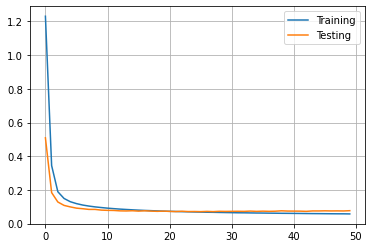

In [27]:
pl.plot(history.history['loss'], label='Training')
pl.plot(history.history['val_loss'], label='Testing')
pl.legend()
pl.grid()

score = model.evaluate(X_test_hog, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Confusion matrix

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


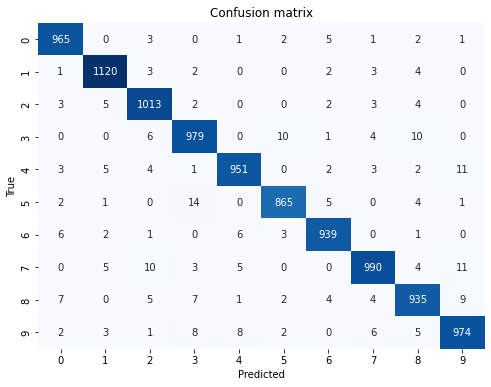

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

pred = model.predict(X_test_hog)
pred = np.argmax(pred, axis=-1)
cm = confusion_matrix(y_test, pred)

# Plot confusion matrix
pl.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
pl.title("Confusion matrix")
pl.xlabel('Predicted')
pl.ylabel('True')
pl.show()